## Liquidity Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid")

In [33]:
df_liquidity = pd.read_csv("../csv_outputs/master_liquidity.csv")
df_lp_holders = pd.read_csv("../csv_outputs/master_lp_holders.csv")
df_liquidity.columns

Index(['token_address', 'chain', 'token_name', 'price_usd', 'liquidity_usd',
       'market_cap_usd', 'liquidity_to_market_cap_ratio', 'token_volume',
       'volume_usd', 'volume_to_liquidity_ratio', 'locked_liquidity_percent',
       'locked_95_for_15_days', 'creator_under_5_percent',
       'creator_percent_of_lp', 'owner_under_5_percent', 'owner_percent_of_lp',
       'total_lp_supply', 'lp_holders_count', 'error'],
      dtype='object')

## Token Price vs Token volume

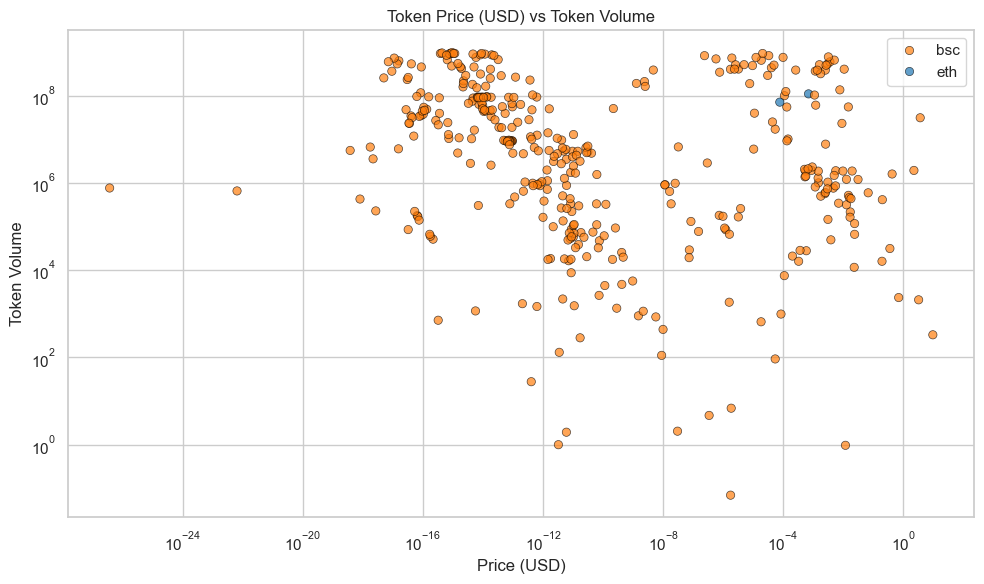

In [37]:
df_liquidity = pd.read_csv("../csv_outputs/master_liquidity.csv")
df_lp_holders = pd.read_csv("../csv_outputs/master_lp_holders.csv")
# Ensure relevant columns are numeric
df_liquidity['price_usd'] = pd.to_numeric(df_liquidity['price_usd'], errors='coerce')
df_liquidity['token_volume'] = pd.to_numeric(df_liquidity['token_volume'], errors='coerce')
df_liquidity['volume_usd'] = pd.to_numeric(df_liquidity['volume_usd'], errors='coerce')

# Drop NaNs for token_volume and price_usd
plot_df = df_liquidity.dropna(subset=['price_usd', 'token_volume', 'volume_usd'])

# Optional: Filter out extreme outliers for better visual clarity
plot_df = plot_df[(plot_df['price_usd'] > 0) & (plot_df['price_usd'] < 10)]  # Adjust price cap
plot_df = plot_df[(plot_df['token_volume'] < 1e9) & (plot_df['volume_usd'] < 1e9)]  # Cap volume

# Plot 1: Price vs Token Volume
plt.figure(figsize=(10, 6))
palette = {
    'eth': '#1f77b4',  # blue
    'bsc': '#ff7f0e'   # orange
}
sns.scatterplot(
    data=plot_df,
    x='price_usd',
    y='token_volume',
    hue='chain',
    palette=palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('Token Price (USD) vs Token Volume')
plt.xlabel('Price (USD)')
plt.ylabel('Token Volume')
plt.xscale('log')  # log scale can help if price values are small
plt.yscale('log')  # helps visualize large volume ranges
plt.legend()
plt.tight_layout()
plt.show()

## Distribution of total LP supply

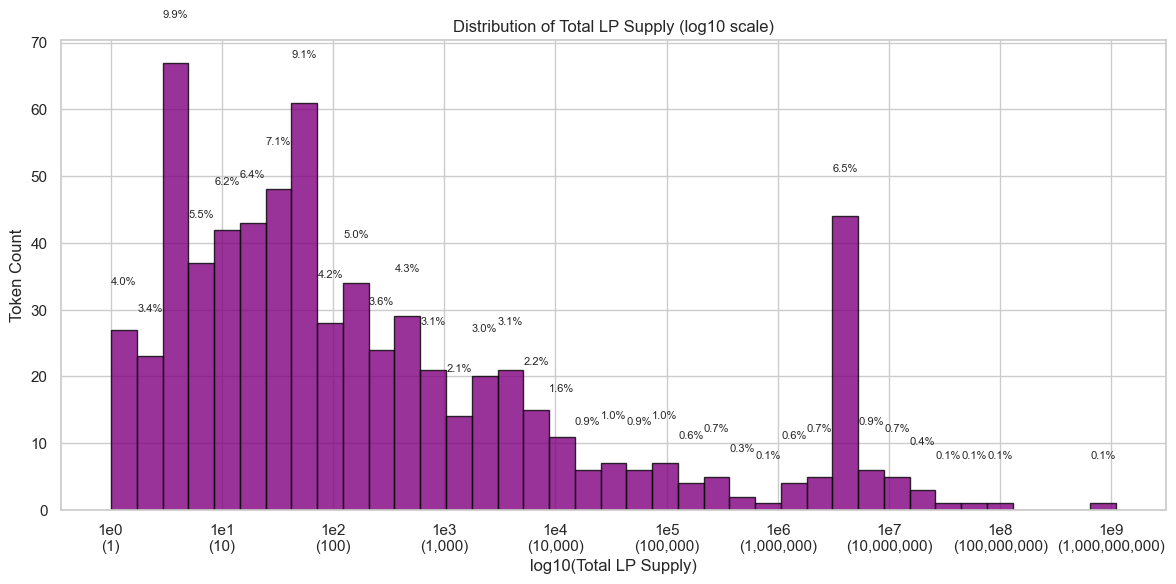

In [43]:
liquidity_df = df_liquidity

# Ensure numeric
liquidity_df['total_lp_supply'] = pd.to_numeric(liquidity_df['total_lp_supply'], errors='coerce')

# Filter out zero or negative LP supply
df_plot = liquidity_df[liquidity_df['total_lp_supply'] > 0].copy()

# Optional: Remove extreme small values (e.g., <1 LP supply)
df_plot = df_plot[df_plot['total_lp_supply'] >= 1]

# Compute log10
df_plot['log_total_lp_supply'] = np.log10(df_plot['total_lp_supply'])

# Plot
plt.figure(figsize=(12, 6))
bins = np.linspace(df_plot['log_total_lp_supply'].min(), df_plot['log_total_lp_supply'].max(), 40)
counts, bins, patches = plt.hist(
    df_plot['log_total_lp_supply'],
    bins=bins,
    color='purple',
    alpha=0.8,
    edgecolor='black'
)

# Annotate percentages
total = counts.sum()
for count, bin_edge in zip(counts, bins[:-1]):
    percent = (count / total) * 100
    if percent > 0:
        plt.text(
            bin_edge + (bins[1] - bins[0]) / 2,
            count + total * 0.01,
            f'{percent:.1f}%',
            ha='center',
            fontsize=8
        )

# X-tick labels: show actual LP values from log10
tick_positions = np.arange(int(df_plot['log_total_lp_supply'].min()), int(df_plot['log_total_lp_supply'].max()) + 1)
tick_labels = [f'1e{int(t)}\n({int(10**t):,})' for t in tick_positions]
plt.xticks(tick_positions, tick_labels)

# Axis labels and title
plt.title('Distribution of Total LP Supply (log10 scale)')
plt.xlabel('log10(Total LP Supply)')
plt.ylabel('Token Count')


plt.tight_layout()
plt.show()

## Distribution by market cap

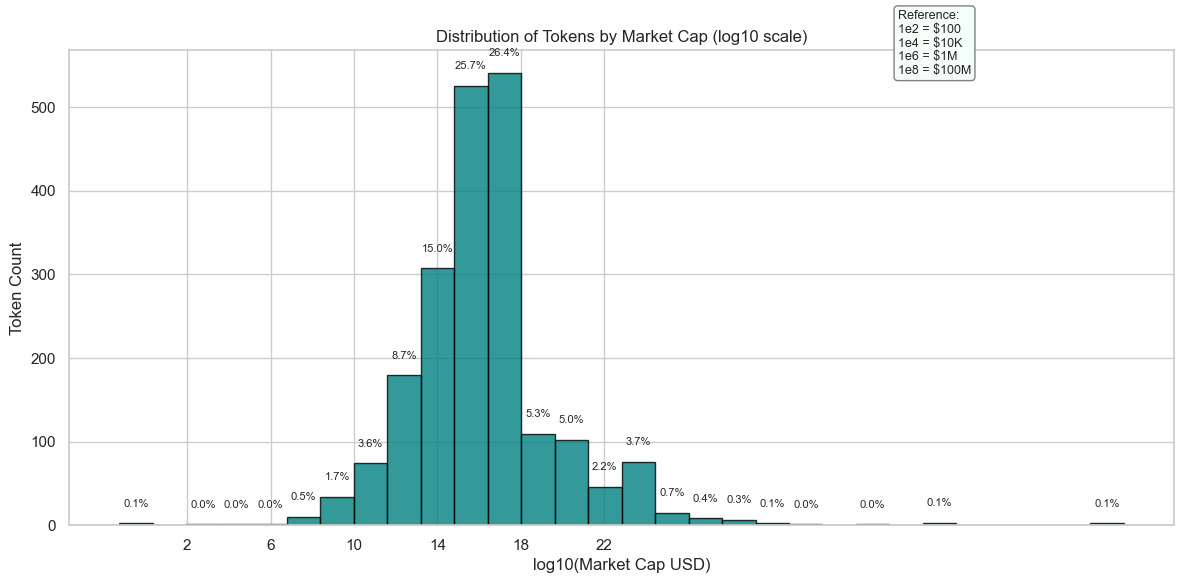

In [59]:
liquidity_df = df_liquidity
# Ensure market_cap_usd is numeric
liquidity_df['market_cap_usd'] = pd.to_numeric(liquidity_df['market_cap_usd'], errors='coerce')

# Filter out invalid values
df_plot = liquidity_df[liquidity_df['market_cap_usd'] > 0].copy()

# Log-transform
df_plot['log_market_cap'] = np.log10(df_plot['market_cap_usd'])

# Plot histogram
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(
    df_plot['log_market_cap'],
    bins=30,
    color='teal',
    edgecolor='black',
    alpha=0.8
)

# Annotate % above bars
total = counts.sum()
for count, bin_left in zip(counts, bins[:-1]):
    percent = (count / total) * 100
    if percent > 0:
        plt.text(
            bin_left + (bins[1] - bins[0]) / 2,
            count + total * 0.01,
            f'{percent:.1f}%',
            ha='center',
            fontsize=8
        )

# Clean and limited X-axis ticks
tick_positions = [2, 6, 10, 14, 18, 22]  # Fewer ticks
tick_labels = [f'1e{t}\n(${int(10.0**t):,})' for t in tick_positions]
plt.xticks(tick_positions)

# Labels
plt.title('Distribution of Tokens by Market Cap (log10 scale)')
plt.xlabel('log10(Market Cap USD)')
plt.ylabel('Token Count')

plt.annotate(
    'Reference:\n'
    '1e2 = $100\n'
    '1e4 = $10K\n'
    '1e6 = $1M\n'
    '1e8 = $100M',
    xy=(0.75, 0.95),
    xycoords='axes fraction',
    fontsize=9,
    bbox=dict(boxstyle="round", fc="mintcream", ec="gray")
)

plt.tight_layout()
plt.show()

## Distribution by liquidity to market cap ratio

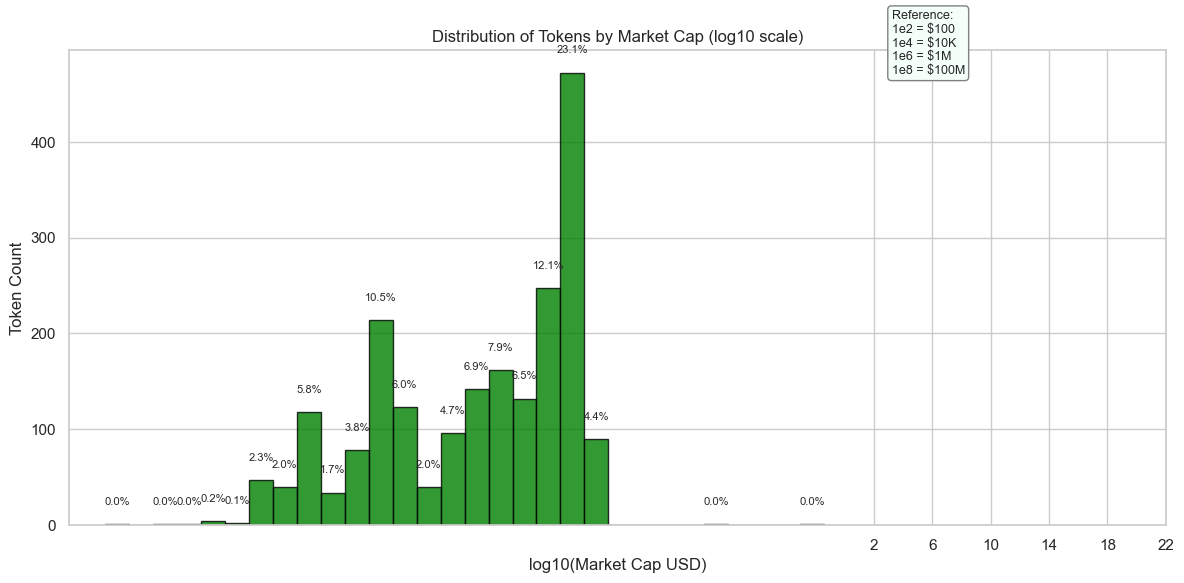

In [61]:
liquidity_df = df_liquidity
# Ensure market_cap_usd is numeric
liquidity_df['liquidity_to_market_cap_ratio'] = pd.to_numeric(liquidity_df['liquidity_to_market_cap_ratio'], errors='coerce')

# Filter out invalid values
df_plot = liquidity_df[liquidity_df['liquidity_to_market_cap_ratio'] > 0].copy()

# Log-transform
df_plot['log_liquidity_to_market_cap_ratio'] = np.log10(df_plot['liquidity_to_market_cap_ratio'])

# Plot histogram
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(
    df_plot['log_liquidity_to_market_cap_ratio'],
    bins=30,
    color='green',
    edgecolor='black',
    alpha=0.8
)

# Annotate % above bars
total = counts.sum()
for count, bin_left in zip(counts, bins[:-1]):
    percent = (count / total) * 100
    if percent > 0:
        plt.text(
            bin_left + (bins[1] - bins[0]) / 2,
            count + total * 0.01,
            f'{percent:.1f}%',
            ha='center',
            fontsize=8
        )

# Clean and limited X-axis ticks
tick_positions = [2, 6, 10, 14, 18, 22]  # Fewer ticks
tick_labels = [f'1e{t}\n(${int(10.0**t):,})' for t in tick_positions]
plt.xticks(tick_positions)

# Labels
plt.title('Distribution of Tokens by Market Cap (log10 scale)')
plt.xlabel('log10(Market Cap USD)')
plt.ylabel('Token Count')

plt.annotate(
    'Reference:\n'
    '1e2 = $100\n'
    '1e4 = $10K\n'
    '1e6 = $1M\n'
    '1e8 = $100M',
    xy=(0.75, 0.95),
    xycoords='axes fraction',
    fontsize=9,
    bbox=dict(boxstyle="round", fc="mintcream", ec="gray")
)

plt.tight_layout()
plt.show()

## Distribution of Liqudity to market cap ratio and volume to liquidity ratio

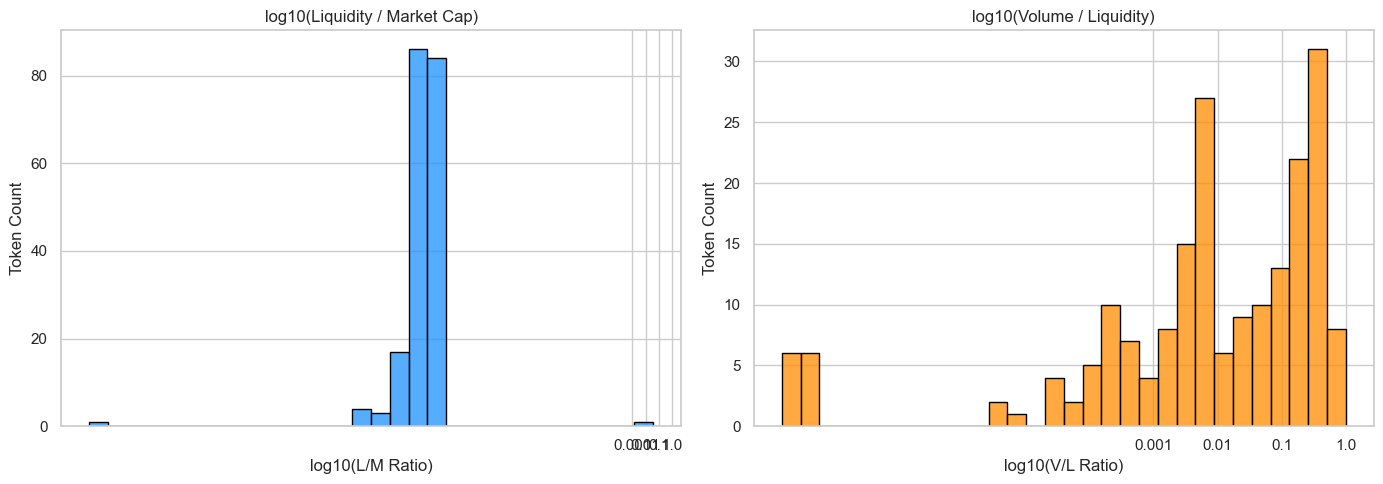

In [63]:
# Ensure numeric
liquidity_df['liquidity_to_market_cap_ratio'] = pd.to_numeric(liquidity_df['liquidity_to_market_cap_ratio'], errors='coerce')
liquidity_df['volume_to_liquidity_ratio'] = pd.to_numeric(liquidity_df['volume_to_liquidity_ratio'], errors='coerce')

# Filter values in (0, 1] to safely apply log10
df_plot = liquidity_df[
    (liquidity_df['liquidity_to_market_cap_ratio'] > 0) & 
    (liquidity_df['liquidity_to_market_cap_ratio'] <= 1) &
    (liquidity_df['volume_to_liquidity_ratio'] > 0) &
    (liquidity_df['volume_to_liquidity_ratio'] <= 1)
].copy()

# Apply log10 transform
df_plot['log_liquidity_to_market_cap_ratio'] = np.log10(df_plot['liquidity_to_market_cap_ratio'])
df_plot['log_volume_to_liquidity_ratio'] = np.log10(df_plot['volume_to_liquidity_ratio'])

# Plot
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Plot 1: log10(Liquidity / Market Cap) ----
sns.histplot(
    df_plot['log_liquidity_to_market_cap_ratio'],
    bins=30,
    kde=False,
    ax=axes[0],
    color='dodgerblue',
    edgecolor='black'
)
axes[0].set_title("log10(Liquidity / Market Cap)")
axes[0].set_xlabel("log10(L/M Ratio)")
axes[0].set_ylabel("Token Count")

# Add reference ticks
axes[0].set_xticks([-3, -2, -1, 0])
axes[0].set_xticklabels([
    "0.001",  # 10^-3
    "0.01",   # 10^-2
    "0.1",    # 10^-1
    "1.0"     # 10^0
])

# ---- Plot 2: log10(Volume / Liquidity) ----
sns.histplot(
    df_plot['log_volume_to_liquidity_ratio'],
    bins=30,
    kde=False,
    ax=axes[1],
    color='darkorange',
    edgecolor='black'
)
axes[1].set_title("log10(Volume / Liquidity)")
axes[1].set_xlabel("log10(V/L Ratio)")
axes[1].set_ylabel("Token Count")

axes[1].set_xticks([-3, -2, -1, 0])
axes[1].set_xticklabels([
    "0.001",
    "0.01",
    "0.1",
    "1.0"
])

plt.tight_layout()
plt.show()

## Market cap and liquidity pool depth

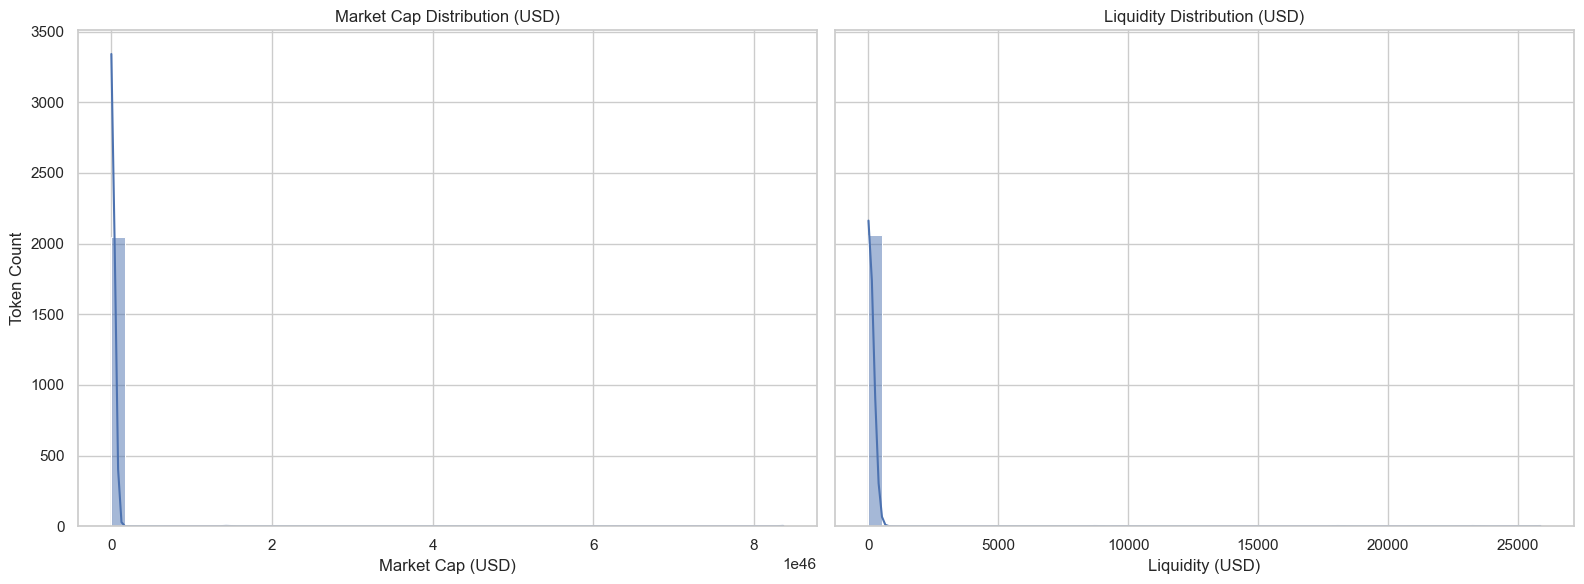

In [6]:
# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Market Cap plot
sns.histplot(ax=axes[0], x=df_liquidity['market_cap_usd'], bins=50, kde=True)
axes[0].set_title('Market Cap Distribution (USD)')
axes[0].set_xlabel('Market Cap (USD)')
axes[0].set_ylabel('Token Count')

# Liquidity plot
sns.histplot(ax=axes[1], x=df_liquidity['liquidity_usd'], bins=50, kde=True)
axes[1].set_title('Liquidity Distribution (USD)')
axes[1].set_xlabel('Liquidity (USD)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

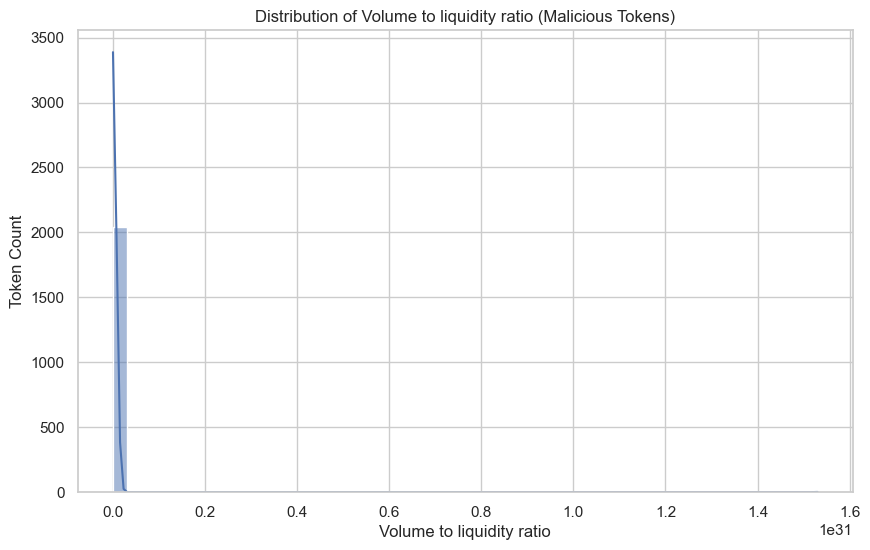

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df_liquidity['volume_to_liquidity_ratio'], bins=50, kde=True)
plt.title('Distribution of Volume to liquidity ratio (Malicious Tokens)')
plt.xlabel('Volume to liquidity ratio')
plt.ylabel('Token Count')
plt.show()



## At least 95% of largest pool's liquidity token burned/locked for 15 days or longer

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_13992\1526592353.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')


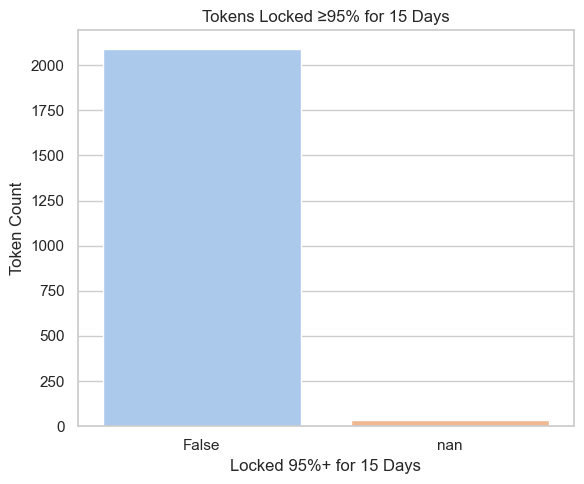

In [8]:
# Clean the column: Convert string to boolean
df_liquidity['locked_95_for_15_days_cleaned'] = df_liquidity['locked_95_for_15_days'].astype(str).str.strip().str.lower().map({
    'true': True,
    'false': False
})

# Count the values
locked_counts = df_liquidity['locked_95_for_15_days_cleaned'].value_counts(dropna=False)

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')
plt.title('Tokens Locked ≥95% for 15 Days')
plt.xlabel('Locked 95%+ for 15 Days')
plt.ylabel('Token Count')
plt.tight_layout()
plt.show()

## Owner/creator wallet contains less than 5% of liquidity

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_13992\3992226970.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')


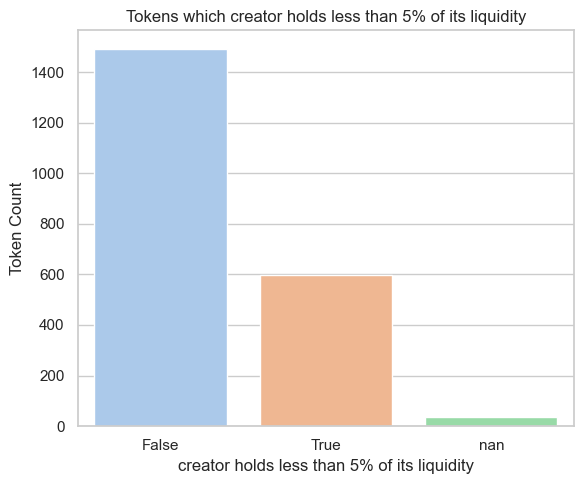

In [9]:
# Clean the column: Convert string to boolean
df_liquidity['creator_under_5_percent_cleaned'] = df_liquidity['creator_under_5_percent'].astype(str).str.strip().str.lower().map({
    'true': True,
    'false': False
})

# Count the values
locked_counts = df_liquidity['creator_under_5_percent_cleaned'].value_counts(dropna=False)

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')
plt.title('Tokens which creator holds less than 5% of its liquidity')
plt.xlabel('creator holds less than 5% of its liquidity')
plt.ylabel('Token Count')
plt.tight_layout()
plt.show()

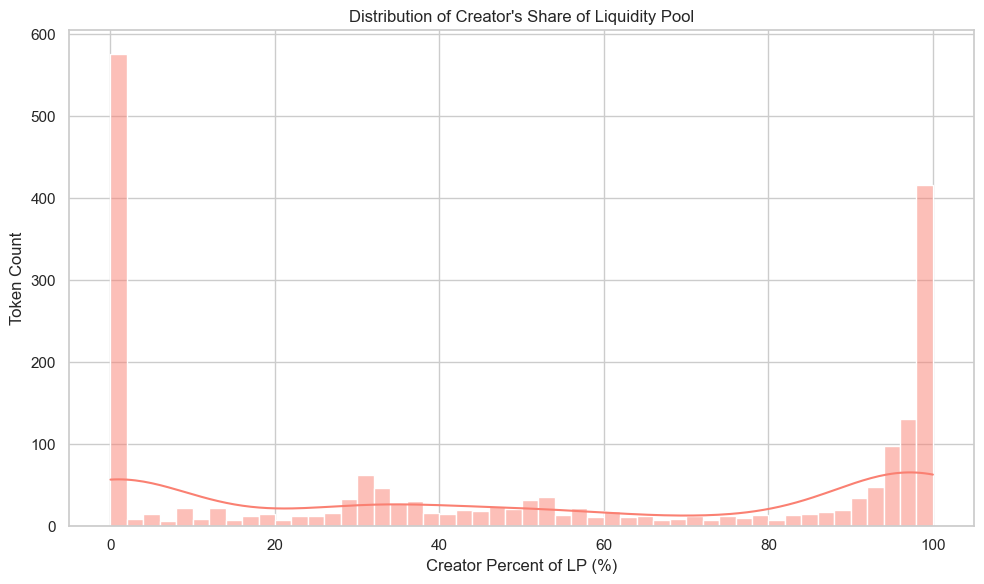

In [10]:
# Optional: Clip values to 0–100% to avoid invalid extremes
df_liquidity['creator_percent_of_lp_clipped'] = pd.to_numeric(df_liquidity['creator_percent_of_lp'], errors='coerce').clip(0, 100)

plt.figure(figsize=(10, 6))
sns.histplot(df_liquidity['creator_percent_of_lp_clipped'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Creator\'s Share of Liquidity Pool')
plt.xlabel('Creator Percent of LP (%)')
plt.ylabel('Token Count')
plt.tight_layout()
plt.show()

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_13992\2115287681.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')


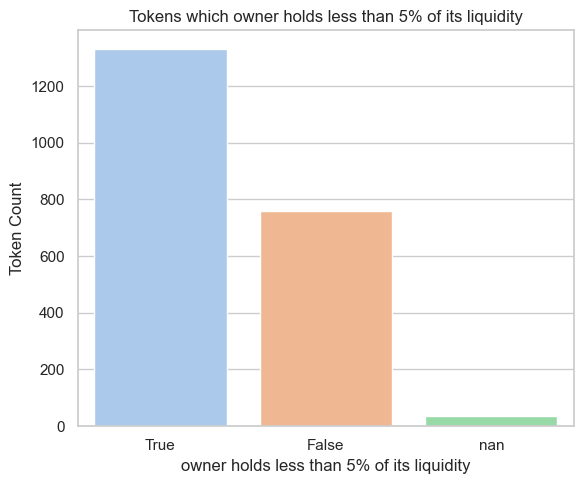

In [11]:

# Clean the column: Convert string to boolean
df_liquidity['owner_under_5_percent_cleaned'] = df_liquidity['owner_under_5_percent'].astype(str).str.strip().str.lower().map({
    'true': True,
    'false': False
})

# Count the values
locked_counts = df_liquidity['owner_under_5_percent_cleaned'].value_counts(dropna=False)

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=locked_counts.index.astype(str), y=locked_counts.values, palette='pastel')
plt.title('Tokens which owner holds less than 5% of its liquidity')
plt.xlabel('owner holds less than 5% of its liquidity')
plt.ylabel('Token Count')
plt.tight_layout()
plt.show()

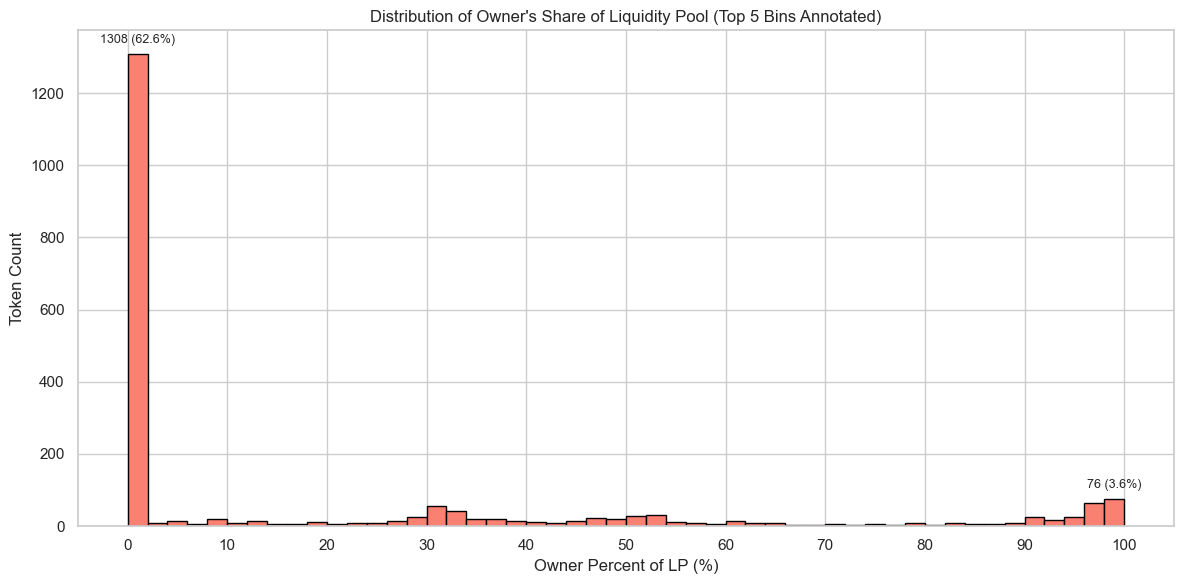

In [12]:
# Ensure data is numeric and clipped to [0, 100]
df_liquidity['owner_percent_of_lp_clipped'] = pd.to_numeric(df_liquidity['owner_percent_of_lp'], errors='coerce').clip(0, 100)

# Generate histogram data
owner_data = df_liquidity['owner_percent_of_lp_clipped'].dropna()
bin_edges = np.linspace(0, 100, 51)  # 50 bins from 0 to 100
counts, edges = np.histogram(owner_data, bins=bin_edges)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
total = counts.sum()

# Identify top 5 bins by count
top_5_indices = np.argsort(counts)[-2:]

# Plot the histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(bin_centers, counts, width=2, color='salmon', edgecolor='black')

# Annotate only the top 5 bars
for i, bar in enumerate(bars):
    if i in top_5_indices and counts[i] > 0:
        percentage = (counts[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.01,
                 f'{counts[i]} ({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

# Titles and labels
plt.title("Distribution of Owner's Share of Liquidity Pool (Top 5 Bins Annotated)")
plt.xlabel("Owner Percent of LP (%)")
plt.ylabel("Token Count")
plt.xticks(np.arange(0, 110, 10))
plt.tight_layout()
plt.show()

## Locked liquidity % distribution

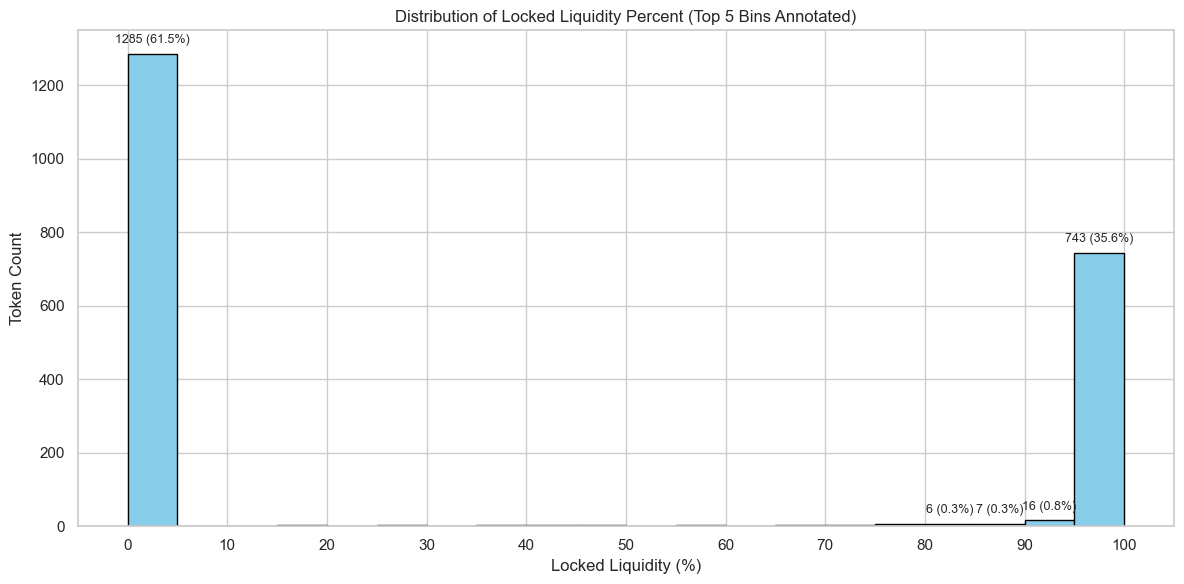

In [13]:
# Clean the data
locked_liquidity = pd.to_numeric(df_liquidity['locked_liquidity_percent'], errors='coerce').clip(0, 100)
df_liquidity['locked_liquidity_percent_cleaned'] = locked_liquidity

# Create histogram data
bin_edges = np.linspace(0, 100, 21)  # 20 bins (5% width)
counts, edges = np.histogram(locked_liquidity.dropna(), bins=bin_edges)
bin_centers = 0.5 * (edges[1:] + edges[:-1])
total = counts.sum()

# Identify indices of top 5 bins
top_5_indices = np.argsort(counts)[-5:]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(bin_centers, counts, width=5, align='center', color='skyblue', edgecolor='black')

# Annotate only top 5 bars
for i, bar in enumerate(bars):
    if i in top_5_indices and counts[i] > 0:
        percentage = (counts[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.01,
                 f'{counts[i]} ({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

# Labels and title
plt.title('Distribution of Locked Liquidity Percent (Top 5 Bins Annotated)')
plt.xlabel('Locked Liquidity (%)')
plt.ylabel('Token Count')
plt.xticks(np.arange(0, 110, 10))
plt.tight_layout()
plt.show()

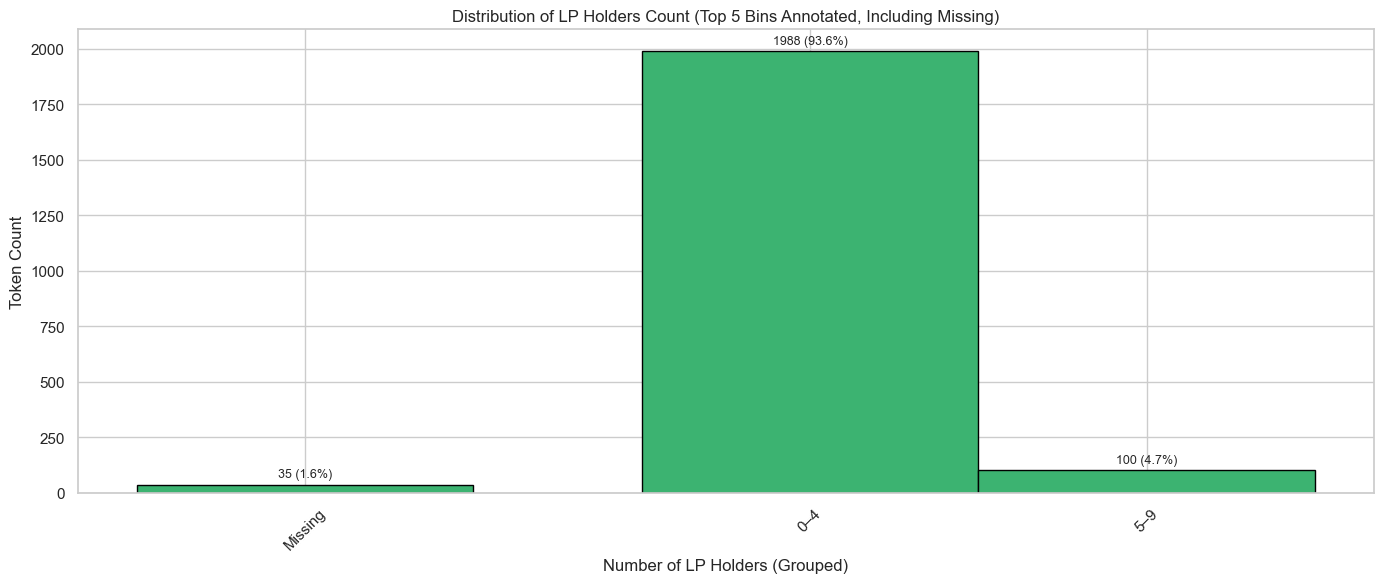

In [14]:
# Convert to numeric
df_liquidity['lp_holders_count_cleaned'] = pd.to_numeric(df_liquidity['lp_holders_count'], errors='coerce')

# Separate non-null and null values
lp_holders_data = df_liquidity['lp_holders_count_cleaned'].dropna()
missing_count = df_liquidity['lp_holders_count_cleaned'].isna().sum()

# Create histogram bins (bin width = 5, capped at 100 for readability)
max_val = lp_holders_data.max()
bin_edges = np.arange(0, min(max_val, 100) + 5, 5)
counts, edges = np.histogram(lp_holders_data, bins=bin_edges)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Add the missing values as an extra bin on the left
bin_centers = np.insert(bin_centers, 0, -5)  # use -5 as placeholder for "Missing"
counts = np.insert(counts, 0, missing_count)
labels = ['Missing'] + [f"{int(edges[i])}–{int(edges[i+1]-1)}" for i in range(len(edges)-1)]
total = counts.sum()

# Identify top 5 bins including missing
top_5_indices = np.argsort(counts)[-5:]

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(bin_centers, counts, width=5, color='mediumseagreen', edgecolor='black')

# Annotate only top 5 bins
for i, bar in enumerate(bars):
    if i in top_5_indices and counts[i] > 0:
        percentage = (counts[i] / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.01,
                 f'{counts[i]} ({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

# Adjust x-axis
xtick_labels = labels
xtick_positions = bin_centers
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)

# Labels and title
plt.title("Distribution of LP Holders Count (Top 5 Bins Annotated, Including Missing)")
plt.xlabel("Number of LP Holders (Grouped)")
plt.ylabel("Token Count")
plt.tight_layout()
plt.show()

Tokens with LP holders >10%: 2052/2122 (96.7%)


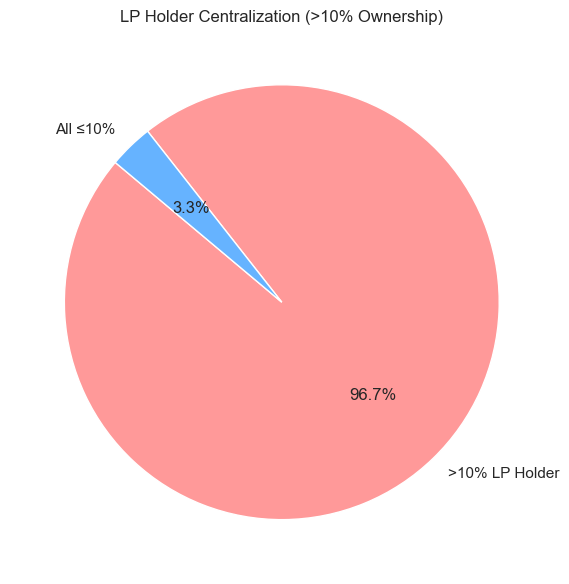

In [15]:
# Focus on holders with >10% of LP
df_top_lp_holders = df_lp_holders[df_lp_holders['percent'] > 10]

# Count how many tokens have LPs held >10% by a single address
top_lp_count = df_top_lp_holders['token_address'].nunique()
total_lp_tokens = df_lp_holders['token_address'].nunique()

print(f"Tokens with LP holders >10%: {top_lp_count}/{total_lp_tokens} ({top_lp_count/total_lp_tokens:.1%})")

# Plot pie chart
labels = ['>10% LP Holder', 'All ≤10%']
sizes = [top_lp_count, total_lp_tokens - top_lp_count]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=140)
plt.title("LP Holder Centralization (>10% Ownership)")
plt.tight_layout()
plt.show()


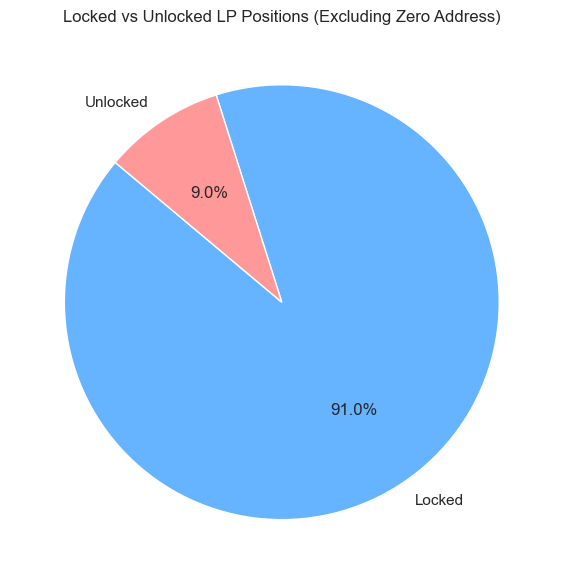

In [16]:
# Clean numeric fields
df_lp_holders['percent'] = pd.to_numeric(df_lp_holders['percent'], errors='coerce')
df_lp_holders['balance'] = pd.to_numeric(df_lp_holders['balance'], errors='coerce')

# Drop rows with missing percent
df_lp_holders = df_lp_holders.dropna(subset=['percent'])

lp_lock_counts = df_lp_holders['is_locked'].value_counts()

# Exclude the 0x000...000 address
zero_address = '0x0000000000000000000000000000000000000000'
df_lp_holders_filtered = df_lp_holders[df_lp_holders['address'].str.lower() != zero_address]

# Locked vs Unlocked LP Distribution (Filtered)
lp_lock_counts = df_lp_holders_filtered['is_locked'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(lp_lock_counts, labels=['Locked', 'Unlocked'], autopct='%1.1f%%', startangle=140,
        colors=['#66b3ff', '#ff9999'])
plt.title("Locked vs Unlocked LP Positions (Excluding Zero Address)")
plt.tight_layout()
plt.show()

## new tests

,token_address,chain,token_name,price_usd,liquidity_usd,market_cap_usd,liquidity_to_market_cap_ratio,token_volume,volume_usd,volume_to_liquidity_ratio,locked_liquidity_percent,locked_95_for_15_days,creator_under_5_percent,creator_percent_of_lp,owner_under_5_percent,owner_percent_of_lp,total_lp_supply,lp_holders_count,error
0,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,2.853240e-07,8.266467e-02,2.804627e+17,2.947440e-19,1.790371e+10,5108.357248,6.179613e+04,99.99,False,True,0.0000,False,82.0128,2.073009e+03,5.0,NaN
1,0x00a6751A376f076779dA4EE9541551b3343939dc,bsc,TERA REBOOT,5.888501e-15,7.418687e-07,4.593031e+12,1.615205e-19,7.540445e+08,0.000004,5.985145e+00,0.00,False,False,28.5409,False,28.5409,1.391061e+02,2.0,NaN
2,0x0aA8e59a6329AEBB991357140d0eE72BE0a974fE,bsc,Zloadr,3.041355e+05,1.915445e-09,3.041355e+17,6.298000e-27,0.000000e+00,0.000000,0.000000e+00,0.00,False,False,98.3400,False,98.3400,5.002245e-11,2.0,Liquidity pool info could not be retrieved.
3,0x0aAbF08760528De1ccBeB498525af25eD86C702c,bsc,Bad Moon,5.130008e-11,1.832261e-06,5.130008e+14,3.571653e-21,0.000000e+00,0.000000,0.000000e+00,0.00,False,False,89.5402,True,0.0000,3.673452e+00,2.0,Liquidity pool info could not be retrieved.
4,0x0AdA00eD9F2caa91b4bEb812Fd64a16aE5569C9B,bsc,House of Dragmoon,5.740627e-03,3.885181e-03,4.302985e+15,9.029036e-19,1.907167e+06,10948.336991,2.817973e+06,100.00,False,True,0.0000,True,0.0000,7.224260e-01,3.0,NaN


,token_address,chain,token_name,address,balance,is_locked,percent,tag
0,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x000000000000000000000000000000000000dead,2.072846e+03,True,0.999921,NaN
1,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x92d9016e71f76ce0878e02545fd965ac946a61c4,1.406889e-01,False,0.000068,NaN
2,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x0ed943ce24baebf257488771759f9bf482c39706,1.798904e-02,False,0.000009,NaN
3,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x7cf6363f9ca257e675e836cc2aa6ad90e7635d41,4.274538e-03,False,0.000002,NaN
4,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x0000000000000000000000000000000000000000,1.000000e-15,True,0.000000,Null Address


Null values in master_liquidity.csv:


token_address                      0
chain                              0
token_name                         0
price_usd                         56
liquidity_usd                     56
market_cap_usd                    77
liquidity_to_market_cap_ratio     77
token_volume                      78
volume_usd                        78
volume_to_liquidity_ratio         78
locked_liquidity_percent          35
locked_95_for_15_days             35
creator_under_5_percent           35
creator_percent_of_lp             35
owner_under_5_percent             35
owner_percent_of_lp               35
total_lp_supply                   35
lp_holders_count                  35
error                            659
dtype: int64

Null values in master_lp_holders.csv:


token_address       0
chain               0
token_name          0
address            54
balance            54
is_locked          54
percent            54
tag              2382
dtype: int64

c:\Users\Famiglia\Desktop\Amedeo\TESI\Progetto_tesi\thesis\.venv\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


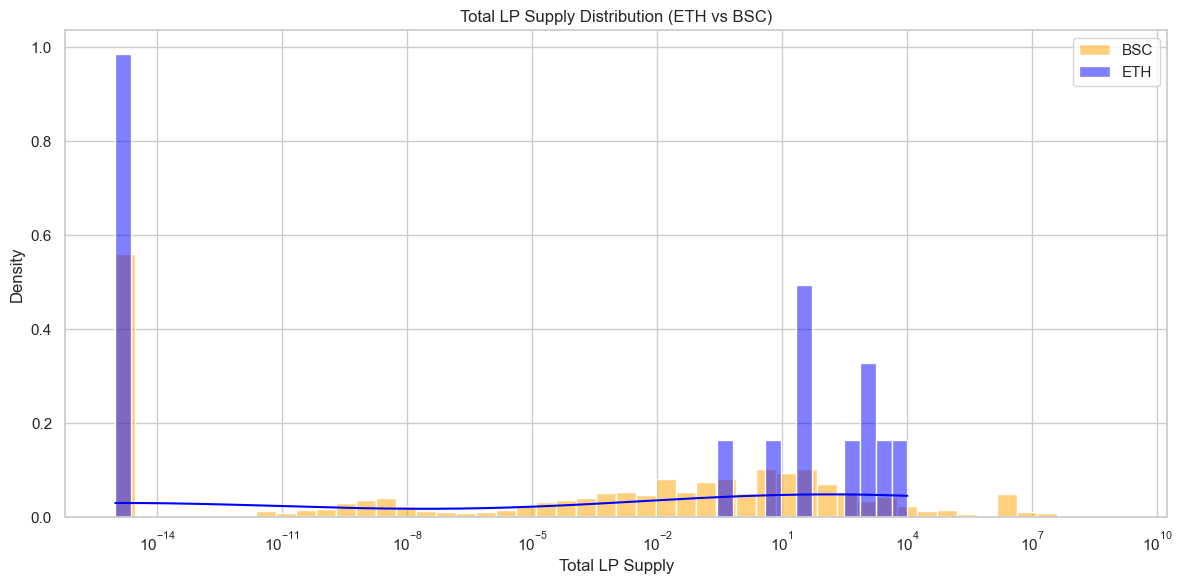

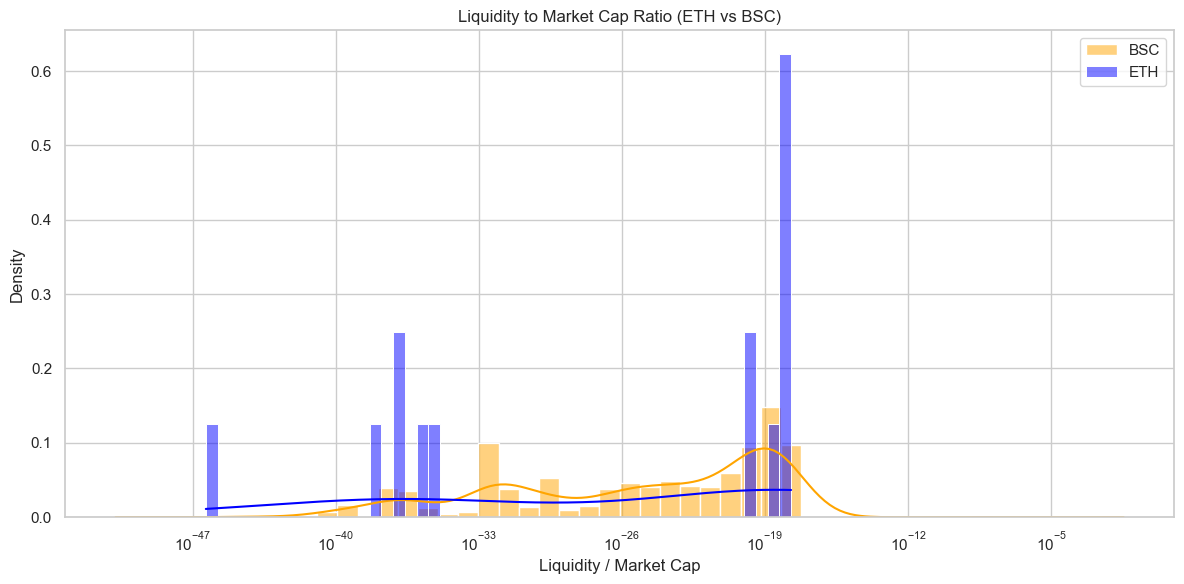

c:\Users\Famiglia\Desktop\Amedeo\TESI\Progetto_tesi\thesis\.venv\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Famiglia\Desktop\Amedeo\TESI\Progetto_tesi\thesis\.venv\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


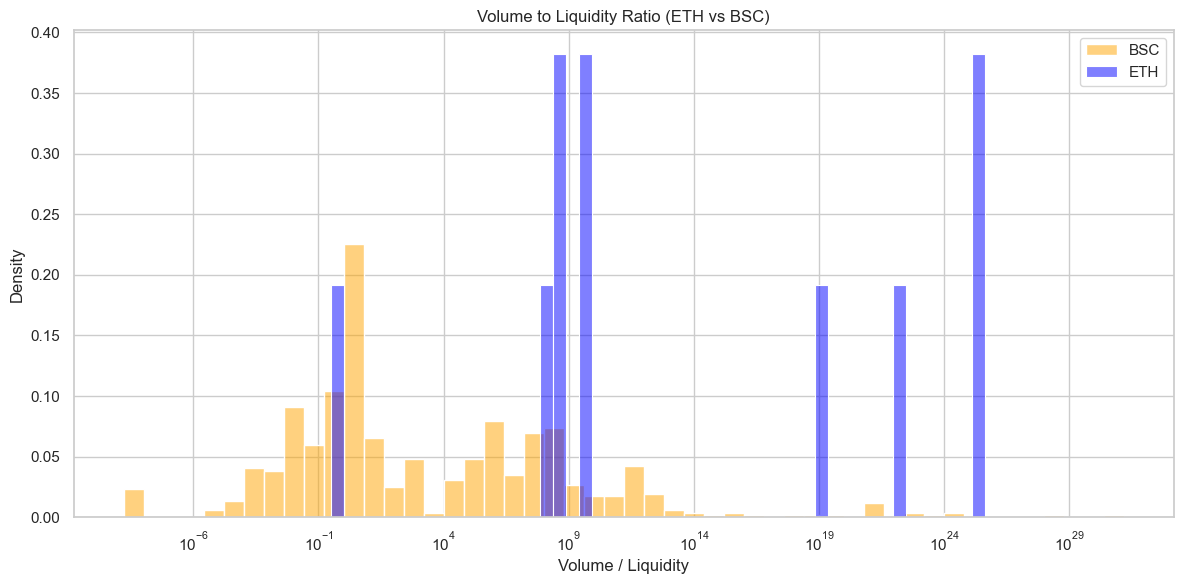

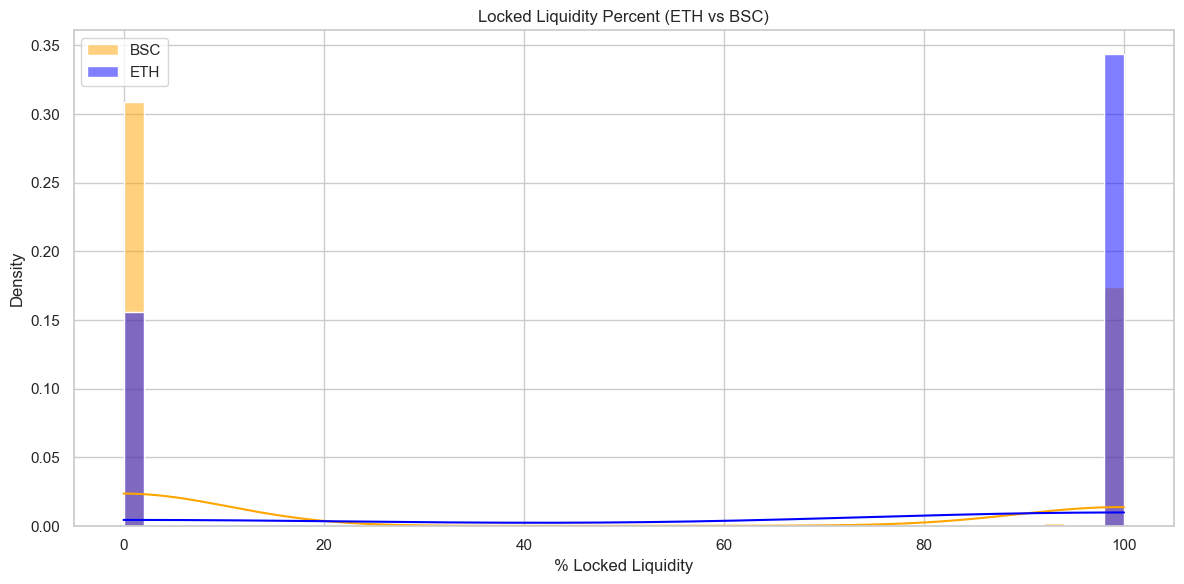

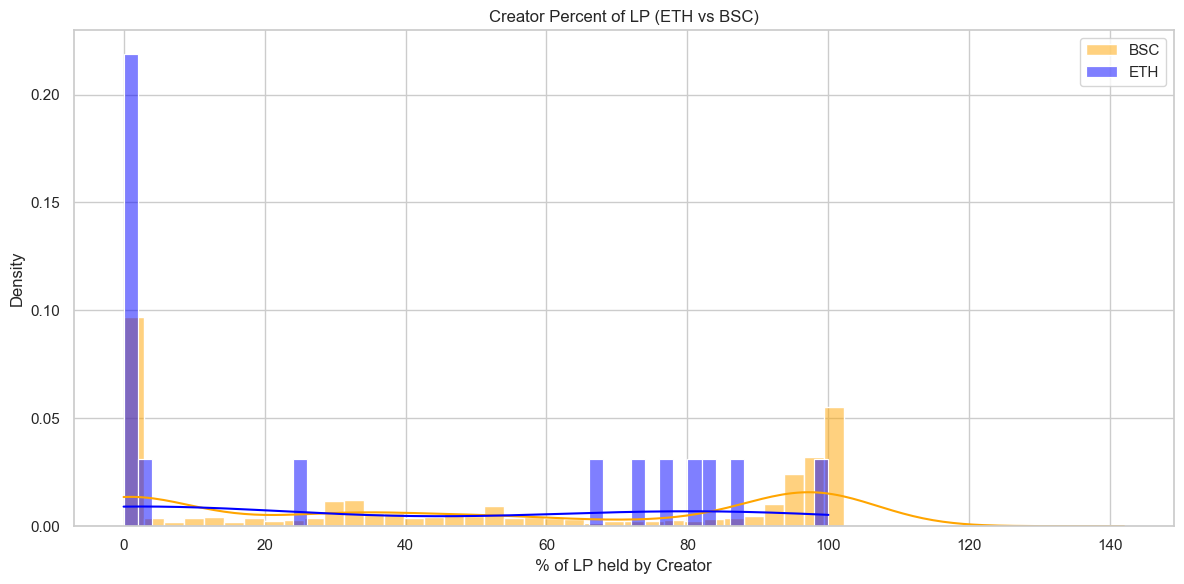

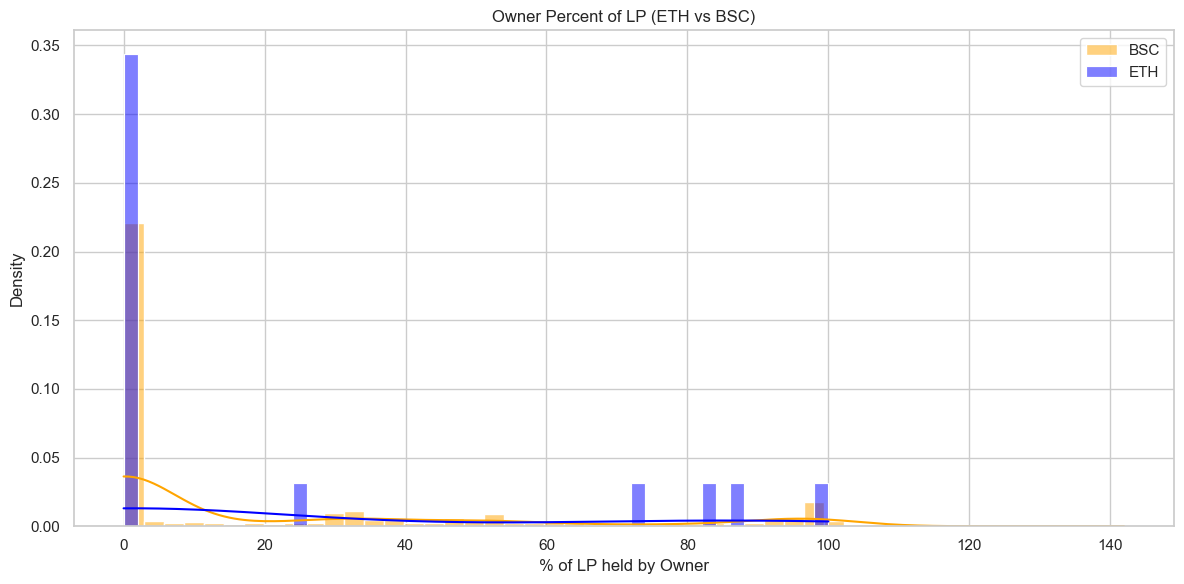

c:\Users\Famiglia\Desktop\Amedeo\TESI\Progetto_tesi\thesis\.venv\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


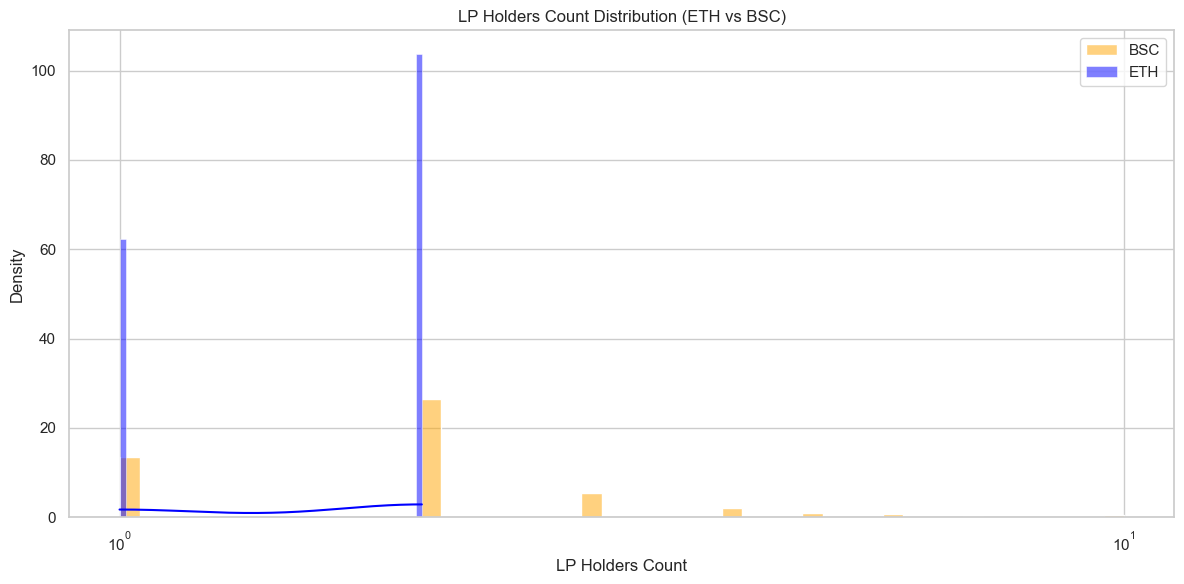

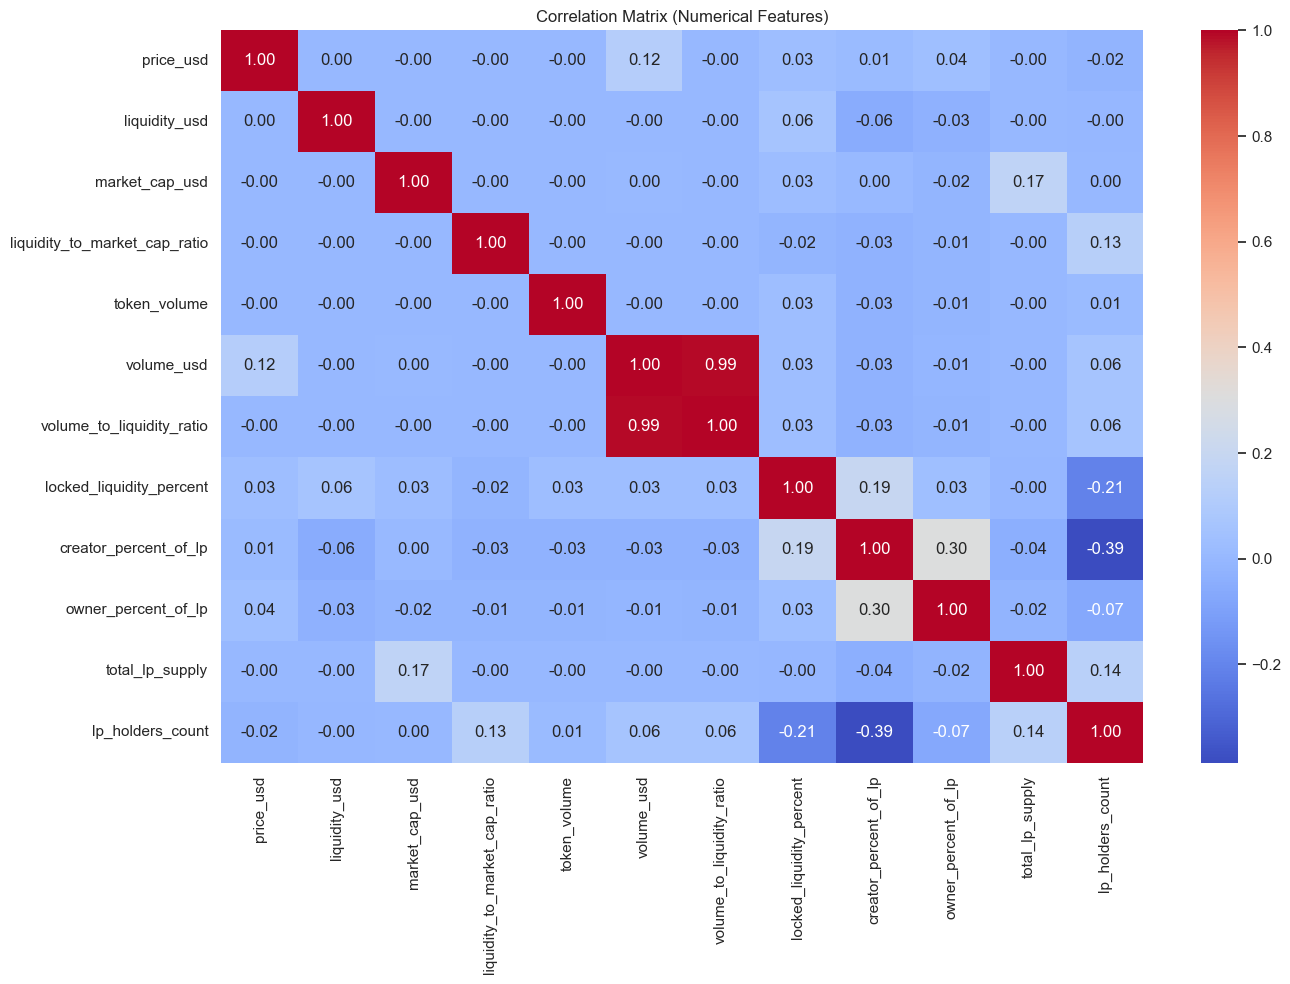


🚩 Suspicious Tokens - Creator holds > 50% of LP: 1029


,token_name,creator_percent_of_lp,chain
2,Zloadr,98.3400,bsc
3,Bad Moon,89.5402,bsc
5,SpaceChain,97.9040,bsc
6,Jigstack,99.4038,bsc
7,GROVE FINANCE,65.1587,bsc
...,...,...,...
2110,Crypto City W,96.9763,bsc
2117,ViperCycle,99.9990,bsc
2118,XEND Finance,97.9426,bsc
2119,NextGenX,99.9968,bsc



🚩 Suspicious Tokens - Owner holds > 50% of LP: 390


,token_name,owner_percent_of_lp,chain
0,Demon,82.0128,bsc
2,Zloadr,98.3400,bsc
5,SpaceChain,97.9040,bsc
11,Baby Cat Inu,94.6955,bsc
18,GUISE,97.3175,bsc
...,...,...,...
2098,Cirus Foundation,98.0024,bsc
2099,CryptoMines,98.8452,bsc
2102,DETY,61.5958,bsc
2107,KIN COIN,50.5588,bsc



🔍 Tokens with < 10 LP Holders: 2067


,token_name,lp_holders_count,chain
0,Demon,5.0,bsc
1,TERA REBOOT,2.0,bsc
2,Zloadr,2.0,bsc
3,Bad Moon,2.0,bsc
4,House of Dragmoon,3.0,bsc
...,...,...,...
2118,XEND Finance,1.0,bsc
2119,NextGenX,1.0,bsc
2120,SuperNomics,2.0,bsc
2121,Evergrande,2.0,bsc


In [21]:
# For displaying all columns
pd.set_option('display.max_columns', None)

# --- Load CSVs ---
df_liquidity = pd.read_csv('../csv_outputs/master_liquidity.csv')
df_lp_holders = pd.read_csv('../csv_outputs/master_lp_holders.csv')

# --- Preview Data ---
display(df_liquidity.head())
display(df_lp_holders.head())

# --- Handle Nulls (Optional: just display for now) ---
print("Null values in master_liquidity.csv:")
display(df_liquidity.isnull().sum())

print("Null values in master_lp_holders.csv:")
display(df_lp_holders.isnull().sum())

# --- Function for Side-by-Side BSC vs ETH Distribution ---
def plot_distribution(metric, title, xlabel, log_scale=False):
    plt.figure(figsize=(12, 6))
    sns.histplot(df_liquidity[df_liquidity['chain'] == 'bsc'][metric].dropna(), 
                 color='orange', label='BSC', kde=True, stat='density', bins=50, log_scale=log_scale)
    sns.histplot(df_liquidity[df_liquidity['chain'] == 'eth'][metric].dropna(), 
                 color='blue', label='ETH', kde=True, stat='density', bins=50, log_scale=log_scale)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Total LP Supply Distribution ---
plot_distribution('total_lp_supply', 'Total LP Supply Distribution (ETH vs BSC)', 'Total LP Supply', log_scale=True)

# --- Liquidity to Market Cap Ratio ---
plot_distribution('liquidity_to_market_cap_ratio', 'Liquidity to Market Cap Ratio (ETH vs BSC)', 'Liquidity / Market Cap', log_scale=True)

# --- Volume to Liquidity Ratio ---
plot_distribution('volume_to_liquidity_ratio', 'Volume to Liquidity Ratio (ETH vs BSC)', 'Volume / Liquidity', log_scale=True)

# --- Locked Liquidity Percent ---
plot_distribution('locked_liquidity_percent', 'Locked Liquidity Percent (ETH vs BSC)', '% Locked Liquidity')

# --- Creator Percent of LP ---
plot_distribution('creator_percent_of_lp', 'Creator Percent of LP (ETH vs BSC)', '% of LP held by Creator')

# --- Owner Percent of LP ---
plot_distribution('owner_percent_of_lp', 'Owner Percent of LP (ETH vs BSC)', '% of LP held by Owner')

# --- LP Holders Count ---
plot_distribution('lp_holders_count', 'LP Holders Count Distribution (ETH vs BSC)', 'LP Holders Count', log_scale=True)

# --- Additional: Correlation Matrix ---
plt.figure(figsize=(14,10))
sns.heatmap(df_liquidity.select_dtypes(include='number').corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()

# --- Additional: Spot Suspicious Patterns ---
# Tokens where creator or owner holds > 50% of LP supply
suspicious_creator = df_liquidity[df_liquidity['creator_percent_of_lp'] > 50]
suspicious_owner = df_liquidity[df_liquidity['owner_percent_of_lp'] > 50]

print(f"\n🚩 Suspicious Tokens - Creator holds > 50% of LP: {len(suspicious_creator)}")
display(suspicious_creator[['token_name', 'creator_percent_of_lp', 'chain']])

print(f"\n🚩 Suspicious Tokens - Owner holds > 50% of LP: {len(suspicious_owner)}")
display(suspicious_owner[['token_name', 'owner_percent_of_lp', 'chain']])

# Optional: Tokens with very low LP holder count
low_lp_holder_tokens = df_liquidity[df_liquidity['lp_holders_count'] < 10]
print(f"\n🔍 Tokens with < 10 LP Holders: {len(low_lp_holder_tokens)}")
display(low_lp_holder_tokens[['token_name', 'lp_holders_count', 'chain']])


Liquidity DataFrame Head:


,token_address,chain,token_name,price_usd,liquidity_usd,market_cap_usd,liquidity_to_market_cap_ratio,token_volume,volume_usd,volume_to_liquidity_ratio,locked_liquidity_percent,locked_95_for_15_days,creator_under_5_percent,creator_percent_of_lp,owner_under_5_percent,owner_percent_of_lp,total_lp_supply,lp_holders_count,error
0,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,2.853240e-07,8.266467e-02,2.804627e+17,2.947440e-19,1.790371e+10,5108.357248,6.179613e+04,99.99,False,True,0.0000,False,82.0128,2.073009e+03,5.0,NaN
1,0x00a6751A376f076779dA4EE9541551b3343939dc,bsc,TERA REBOOT,5.888501e-15,7.418687e-07,4.593031e+12,1.615205e-19,7.540445e+08,0.000004,5.985145e+00,0.00,False,False,28.5409,False,28.5409,1.391061e+02,2.0,NaN
2,0x0aA8e59a6329AEBB991357140d0eE72BE0a974fE,bsc,Zloadr,3.041355e+05,1.915445e-09,3.041355e+17,6.298000e-27,0.000000e+00,0.000000,0.000000e+00,0.00,False,False,98.3400,False,98.3400,5.002245e-11,2.0,Liquidity pool info could not be retrieved.
3,0x0aAbF08760528De1ccBeB498525af25eD86C702c,bsc,Bad Moon,5.130008e-11,1.832261e-06,5.130008e+14,3.571653e-21,0.000000e+00,0.000000,0.000000e+00,0.00,False,False,89.5402,True,0.0000,3.673452e+00,2.0,Liquidity pool info could not be retrieved.
4,0x0AdA00eD9F2caa91b4bEb812Fd64a16aE5569C9B,bsc,House of Dragmoon,5.740627e-03,3.885181e-03,4.302985e+15,9.029036e-19,1.907167e+06,10948.336991,2.817973e+06,100.00,False,True,0.0000,True,0.0000,7.224260e-01,3.0,NaN



LP Holders DataFrame Head:


,token_address,chain,token_name,address,balance,is_locked,percent,tag
0,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x000000000000000000000000000000000000dead,2.072846e+03,True,0.999921,NaN
1,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x92d9016e71f76ce0878e02545fd965ac946a61c4,1.406889e-01,False,0.000068,NaN
2,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x0ed943ce24baebf257488771759f9bf482c39706,1.798904e-02,False,0.000009,NaN
3,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x7cf6363f9ca257e675e836cc2aa6ad90e7635d41,4.274538e-03,False,0.000002,NaN
4,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x0000000000000000000000000000000000000000,1.000000e-15,True,0.000000,Null Address



Liquidity DataFrame Nulls:


token_address                      0
chain                              0
token_name                         0
price_usd                         56
liquidity_usd                     56
market_cap_usd                    77
liquidity_to_market_cap_ratio     77
token_volume                      78
volume_usd                        78
volume_to_liquidity_ratio         78
locked_liquidity_percent          35
locked_95_for_15_days             35
creator_under_5_percent           35
creator_percent_of_lp             35
owner_under_5_percent             35
owner_percent_of_lp               35
total_lp_supply                   35
lp_holders_count                  35
error                            659
dtype: int64


LP Holders DataFrame Nulls:


token_address       0
chain               0
token_name          0
address            54
balance            54
is_locked          54
percent            54
tag              2382
dtype: int64


Basic Statistics (Liquidity):


,price_usd,liquidity_usd,market_cap_usd,liquidity_to_market_cap_ratio,token_volume,volume_usd,volume_to_liquidity_ratio,locked_liquidity_percent,creator_percent_of_lp,owner_percent_of_lp,total_lp_supply,lp_holders_count
count,2.067000e+03,2.067000e+03,2.046000e+03,2.046000e+03,2.045000e+03,2.045000e+03,2.045000e+03,2088.000000,2088.000000,2088.000000,2.088000e+03,2088.000000
mean,2.140115e+16,4.144810e+01,4.785335e+43,1.750068e-05,1.322647e+14,1.671064e+25,7.498323e+27,37.552754,50.645666,20.732226,7.988575e+05,2.134100
std,9.728834e+17,9.061631e+02,1.875832e+45,7.916036e-04,5.659027e+15,6.745108e+26,3.384024e+29,47.949405,41.125982,32.753025,2.411512e+07,1.342685
min,0.000000e+00,0.000000e+00,5.608022e-02,1.673496e-51,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,8.367198e-12,2.406491e-14,2.870219e+14,2.150982e-32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.003025,0.000000,1.000000e-15,1.000000
50%,6.007897e-08,1.433828e-08,1.257971e+16,2.146449e-24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,48.522150,0.000000,1.957769e-03,2.000000
75%,8.669807e+01,1.306296e-06,1.888750e+17,5.527240e-20,8.087884e+05,6.606183e-07,1.996180e-01,100.000000,96.447400,34.019175,8.254585e+00,2.000000
max,4.423144e+19,2.587754e+04,8.364934e+46,3.580639e-02,2.558811e+17,3.027167e+28,1.530311e+31,100.000000,141.932100,141.932100,1.093685e+09,10.000000


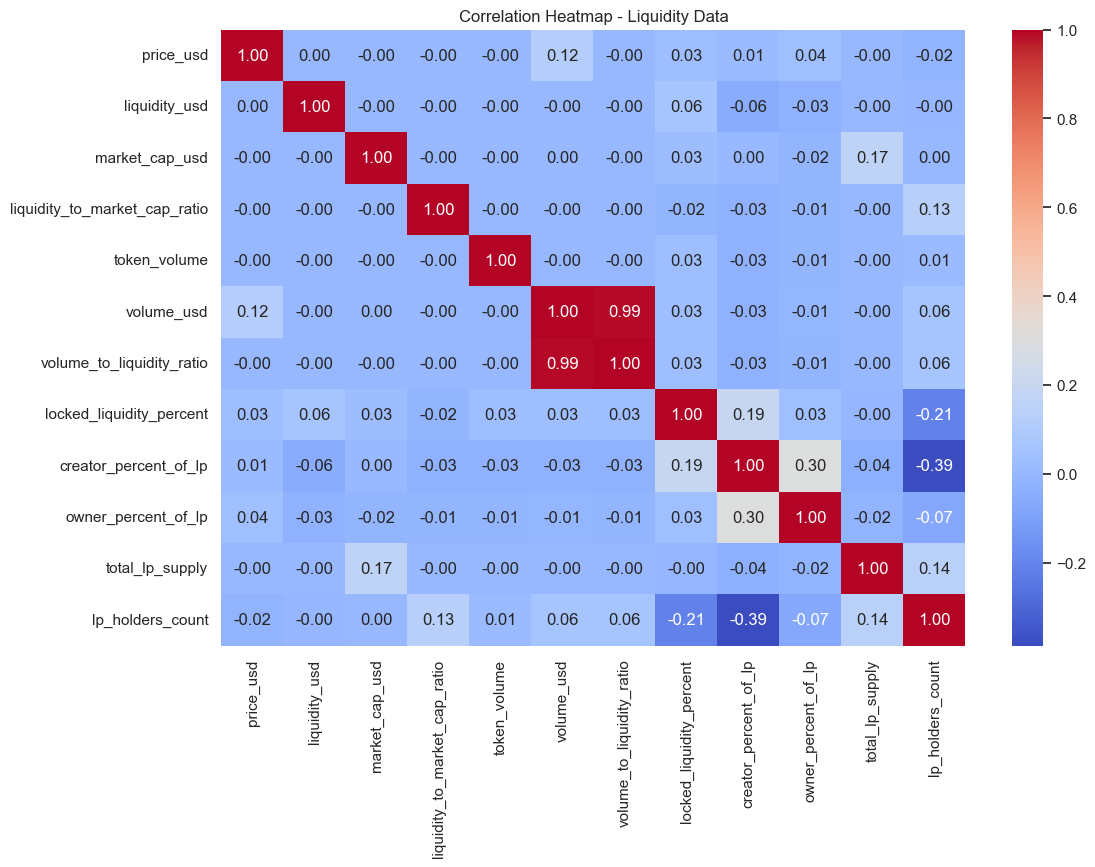


Total unique suspicious tokens: 2086


,token_name,token_address,chain,liquidity_to_market_cap_ratio,creator_percent_of_lp,owner_percent_of_lp,locked_liquidity_percent,volume_to_liquidity_ratio
0,Demon,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,2.947440e-19,0.0000,82.0128,99.99,6.179613e+04
1,TERA REBOOT,0x00a6751A376f076779dA4EE9541551b3343939dc,bsc,1.615205e-19,28.5409,28.5409,0.00,5.985145e+00
2,Zloadr,0x0aA8e59a6329AEBB991357140d0eE72BE0a974fE,bsc,6.298000e-27,98.3400,98.3400,0.00,0.000000e+00
3,Bad Moon,0x0aAbF08760528De1ccBeB498525af25eD86C702c,bsc,3.571653e-21,89.5402,0.0000,0.00,0.000000e+00
4,House of Dragmoon,0x0AdA00eD9F2caa91b4bEb812Fd64a16aE5569C9B,bsc,9.029036e-19,0.0000,0.0000,100.00,2.817973e+06
...,...,...,...,...,...,...,...,...
1457,WSB INU,0xb0b108DFC61E4FFA315A3f3E147d63aD81837bB5,bsc,NaN,0.0000,0.0000,0.00,NaN
1507,QunatumX,0xB3E5F9D734eb0E7d251A4291fcB38c57b7ec0Dde,bsc,NaN,0.0000,0.0000,0.00,NaN
1601,NapNow,0xc5d668850c1A5f25F4a5e972214805d4250359C9,bsc,NaN,0.0000,0.0000,0.00,NaN
1669,Suleyman Cakır,0xC98E5e5e209aA40801F867985b498fcAF084c699,bsc,NaN,5.8794,5.8794,0.00,NaN


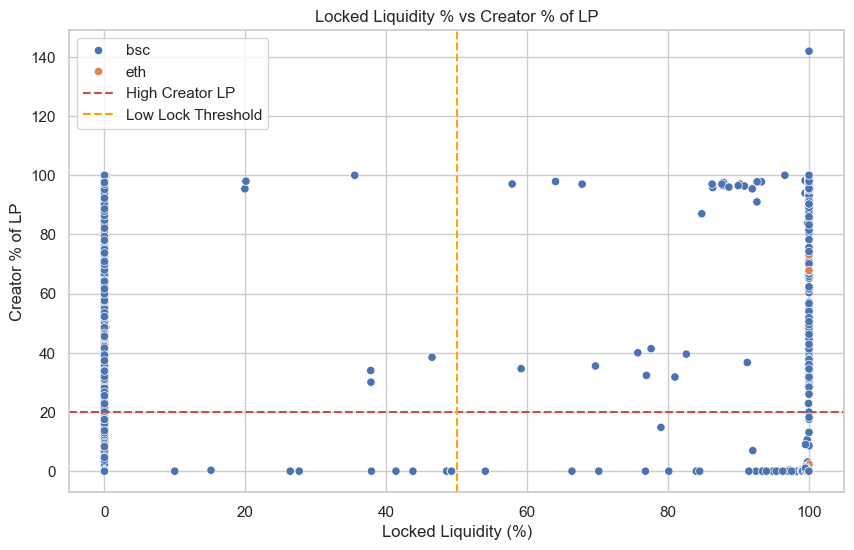


Tokens with LP holders holding more than 20%:


,token_address,chain,percent
3,0x007C5Ade505C1455a072207b0C5b9CF3Ac79B251,bsc,3.386768e+06
94,0x0D7486d68e29eb5589c79e7392C16CDF04854663,bsc,3.240699e+06
388,0x2dBF59F42c746802f8B47AeeEc010E294D455bAe,bsc,6.331500e+10
417,0x329920B99060cC3B6429bE5B1013F27e02A55C50,bsc,2.825949e+08
422,0x332D89C9361daB1cb0c31A59ecadd3F16F39bB55,bsc,4.964138e+03
442,0x36A49E9DCDfEa8d6d5C1D9F7228FDCfb6E2bDA9b,bsc,3.484196e+03
487,0x3C3DCc5349ff730a00a518709696EC31A4201A4A,bsc,5.828015e+13
556,0x44Bd3Be114B8282FC9D1D12B7C43500211bbad3f,bsc,3.116967e+15
641,0x4d4D0eADfd174e6c47282F53293Bbc0f91E239d2,bsc,3.393777e+04
699,0x55B6EF305B29Eb33AF5431d06fb432de120d4e15,bsc,2.155145e+04



Tokens with Errors Flagged:


,token_name,token_address,chain,error
2,Zloadr,0x0aA8e59a6329AEBB991357140d0eE72BE0a974fE,bsc,Liquidity pool info could not be retrieved.
3,Bad Moon,0x0aAbF08760528De1ccBeB498525af25eD86C702c,bsc,Liquidity pool info could not be retrieved.
5,SpaceChain,0x0Af8ca33916D42362e115416BFc432e46558d04f,bsc,Liquidity pool info could not be retrieved.
6,Jigstack,0x0B9fb7FeF33610958795AAaa80b5D5927763e51d,bsc,Liquidity pool info could not be retrieved.
7,GROVE FINANCE,0x0B931CaD9077f3Bb9f6F8aa513626D30da8F2202,bsc,Liquidity pool info could not be retrieved.
...,...,...,...,...
2118,XEND Finance,0xFF03a7feb0c827F55165656697331064ABD71f68,bsc,Liquidity pool info could not be retrieved.
2119,NextGenX,0xFF82275F985170CA9F9EcCf3e65bd6207E13395B,bsc,Liquidity pool info could not be retrieved.
2120,SuperNomics,0xfFAed3d9774f321a4DADdc972d13C8f994f07337,bsc,Liquidity pool info could not be retrieved.
2121,Evergrande,0xffb0E8162d6726214914d2480CC6A6E5915EB0DD,bsc,Liquidity pool info could not be retrieved.


In [23]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# Load CSVs
liquidity_df = pd.read_csv('../csv_outputs/master_liquidity.csv')
lp_holders_df = pd.read_csv('../csv_outputs/master_lp_holders.csv')

# === 1. Basic Overview ===
print("Liquidity DataFrame Head:")
display(liquidity_df.head())

print("\nLP Holders DataFrame Head:")
display(lp_holders_df.head())

print("\nLiquidity DataFrame Nulls:")
display(liquidity_df.isnull().sum())

print("\nLP Holders DataFrame Nulls:")
display(lp_holders_df.isnull().sum())

# === 2. Data Cleaning (Optional) ===
# Drop rows with critical nulls or flag them for review
liquidity_df_cleaned = liquidity_df.copy()
lp_holders_df_cleaned = lp_holders_df.copy()

# === 3. Basic Stats & Distributions ===
print("\nBasic Statistics (Liquidity):")
display(liquidity_df.describe())

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(liquidity_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap - Liquidity Data')
plt.show()

# === 4. Red Flag Detection / Malicious Patterns ===

# 1. Low liquidity-to-market cap ratio
low_liq_mc_ratio = liquidity_df[liquidity_df['liquidity_to_market_cap_ratio'] < 0.1]

# 2. Very high creator or owner percent of LP
high_creator_lp = liquidity_df[liquidity_df['creator_percent_of_lp'] > 20]
high_owner_lp = liquidity_df[liquidity_df['owner_percent_of_lp'] > 20]

# 3. Locked liquidity too low
low_locked_liquidity = liquidity_df[liquidity_df['locked_liquidity_percent'] < 50]

# 4. Very high volume relative to liquidity (possible wash trading)
high_volume_liquidity_ratio = liquidity_df[liquidity_df['volume_to_liquidity_ratio'] > 5]

# 5. Creator or owner holds >5% of LP but not flagged
potential_hidden_ownership = liquidity_df[
    ((liquidity_df['creator_under_5_percent'] == True) & (liquidity_df['creator_percent_of_lp'] > 5)) |
    ((liquidity_df['owner_under_5_percent'] == True) & (liquidity_df['owner_percent_of_lp'] > 5))
]

# 6. LP Holders with high % not marked as locked
unlocked_whales = lp_holders_df[
    (lp_holders_df['percent'] > 10) & (lp_holders_df['is_locked'] == False)
]

# === 5. Summary of Flagged Tokens ===
suspicious_tokens = pd.concat([
    low_liq_mc_ratio,
    high_creator_lp,
    high_owner_lp,
    low_locked_liquidity,
    high_volume_liquidity_ratio,
    potential_hidden_ownership
]).drop_duplicates(subset=['token_address', 'chain'])

print(f"\nTotal unique suspicious tokens: {suspicious_tokens.shape[0]}")
display(suspicious_tokens[['token_name', 'token_address', 'chain', 'liquidity_to_market_cap_ratio',
                           'creator_percent_of_lp', 'owner_percent_of_lp',
                           'locked_liquidity_percent', 'volume_to_liquidity_ratio']])

# === 6. Visualization ===
# Locked Liquidity vs Creator Ownership
plt.figure(figsize=(10, 6))
sns.scatterplot(data=liquidity_df, x='locked_liquidity_percent', y='creator_percent_of_lp', hue='chain')
plt.title('Locked Liquidity % vs Creator % of LP')
plt.xlabel('Locked Liquidity (%)')
plt.ylabel('Creator % of LP')
plt.axhline(20, color='r', linestyle='--', label='High Creator LP')
plt.axvline(50, color='orange', linestyle='--', label='Low Lock Threshold')
plt.legend()
plt.show()

# === 7. LP Holders Analysis ===
# Group LP holders by token to find top whales
top_holders = lp_holders_df.groupby(['token_address', 'chain'])['percent'].max().reset_index()
top_holders = top_holders[top_holders['percent'] > 20]

print("\nTokens with LP holders holding more than 20%:")
display(top_holders)

# === 8. Errors Summary ===
print("\nTokens with Errors Flagged:")
errors_df = liquidity_df[liquidity_df['error'].notnull()]
display(errors_df[['token_name', 'token_address', 'chain', 'error']])
